<a href="https://colab.research.google.com/github/anaisabelveg/tfm/blob/main/Regresion_lineal_multiple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importamos las librerias necesarias y configuramos matplotlib

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
from scipy import stats
plt.rcParams['image.cmap'] = "bwr"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')

Selecciono el dataset

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving transit_limpio.csv to transit_limpio.csv


Creo el dataframe a partir del dataset subido

In [ ]:
dfTransit = pd.read_csv("transit_limpio.csv")
print(dfTransit.head(10))

                 region  price    year  cylinders  fuel  odometer  \
0            birmingham  31900  2019.0          6     1   29497.0   
1            birmingham  32900  2019.0          6     1    6735.0   
2            birmingham  34500  2019.0          6     1    7646.0   
3            birmingham  32700  2019.0          6     1   13646.0   
4            birmingham  32900  2019.0          6     1    6735.0   
5            birmingham  34800  2019.0          6     1   31020.0   
6            birmingham  32800  2018.0          6     1   43479.0   
7            birmingham  38300  2020.0          6     1    7540.0   
8            birmingham  34800  2019.0          6     1   31020.0   
9  huntsville / decatur  14882  2015.0          6     1  151780.0   

   title_status  transmission  drive        lat       long  
0             1             1      1  36.464100 -86.658280  
1             1             1      1  36.464100 -86.658280  
2             1             1      1  36.464100 -86.65828

Correlación entre las variables

In [ ]:
def tidy_corr_matrix(corr_mat):
    '''
    Función para convertir una matriz de correlación de pandas en formato tidy
    '''
    corr_mat = corr_mat.stack().reset_index()
    corr_mat.columns = ['variable_1','variable_2','r']
    corr_mat = corr_mat.loc[corr_mat['variable_1'] != corr_mat['variable_2'], :]
    corr_mat['abs_r'] = np.abs(corr_mat['r'])
    corr_mat = corr_mat.sort_values('abs_r', ascending=False)
    
    return(corr_mat)



corr_matrix = dfTransit.select_dtypes(include=['float64', 'int']).corr(method='pearson')
tidy_corr_matrix(corr_matrix).head(10)

,variable_1,variable_2,r,abs_r
41,odometer,year,-0.715429,0.715429
14,year,odometer,-0.715429,0.715429
1,price,year,0.676811,0.676811
10,year,price,0.676811,0.676811
4,price,odometer,-0.671098,0.671098
40,odometer,price,-0.671098,0.671098
72,drive,cylinders,-0.666335,0.666335
27,cylinders,drive,-0.666335,0.666335
12,year,cylinders,0.334502,0.334502
21,cylinders,year,0.334502,0.334502


Matriz de correlaciones

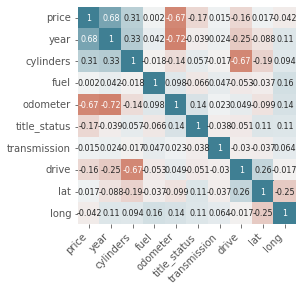

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))

sns.heatmap(
    corr_matrix,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 8},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = sns.diverging_palette(20, 220, n=200),
    square    = True,
    ax        = ax
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)

ax.tick_params(labelsize = 10)

Divido el dataframe con un 80% de entrenamiento y el resto 20% para el test.


In [ ]:
X = dfTransit[['year', 'odometer', 'cylinders','title_status','drive']]
y = dfTransit['price']

X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y.values.reshape(-1,1),
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

Creación del modelo utilizando scikitlearn

In [ ]:
# A la matriz de predictores se le tiene que añadir una columna de 1s para el intercept del modelo
X_train = sm.add_constant(X_train, prepend=True)
modelo = sm.OLS(endog=y_train, exog=X_train,)
modelo = modelo.fit()
print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.503
Model:                            OLS   Adj. R-squared:                  0.494
Method:                 Least Squares   F-statistic:                     56.81
Date:                Mon, 17 Oct 2022   Prob (F-statistic):           1.08e-40
Time:                        20:32:32   Log-Likelihood:                -2918.1
No. Observations:                 287   AIC:                             5848.
Df Residuals:                     281   BIC:                             5870.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -3.086e+06   6.02e+05     -5.130   

Intervalos de confianza para los coeficientes del modelo

In [ ]:
intervalos_ci = modelo.conf_int(alpha=0.05)
intervalos_ci.columns = ['2.5%', '97.5%']
intervalos_ci

,2.5%,97.5%
const,-4.269857e+06,-1.901731e+06
year,9.475597e+02,2.121952e+03
odometer,-9.959355e-02,-5.242393e-02
cylinders,1.280064e+03,6.265023e+03
title_status,-5.162574e+03,-8.425212e+02
drive,-1.188028e+03,7.143736e+03


errores (residuos) de las predicciones de entrenamiento

In [ ]:
y_train = y_train.flatten()
prediccion_train = modelo.predict(exog = X_train)
residuos_train   = prediccion_train - y_train

Gráficos

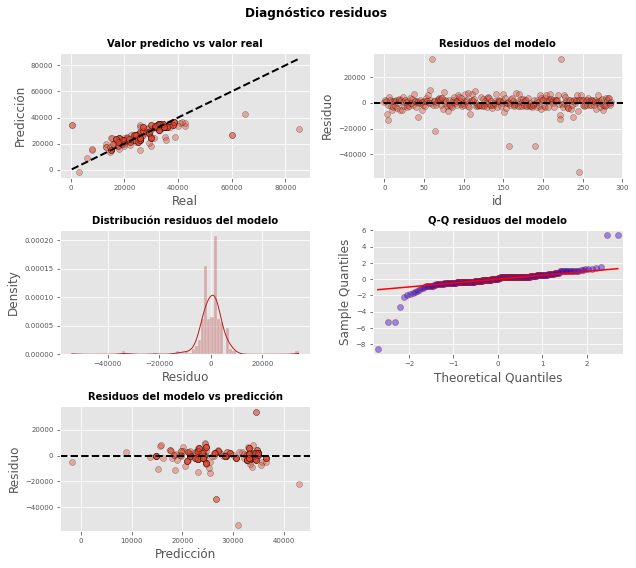

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(9, 8))

axes[0, 0].scatter(y_train, prediccion_train, edgecolors=(0, 0, 0), alpha = 0.4)
axes[0, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()],
                'k--', color = 'black', lw=2)
axes[0, 0].set_title('Valor predicho vs valor real', fontsize = 10, fontweight = "bold")
axes[0, 0].set_xlabel('Real')
axes[0, 0].set_ylabel('Predicción')
axes[0, 0].tick_params(labelsize = 7)

axes[0, 1].scatter(list(range(len(y_train))), residuos_train,
                   edgecolors=(0, 0, 0), alpha = 0.4)
axes[0, 1].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
axes[0, 1].set_title('Residuos del modelo', fontsize = 10, fontweight = "bold")
axes[0, 1].set_xlabel('id')
axes[0, 1].set_ylabel('Residuo')
axes[0, 1].tick_params(labelsize = 7)

sns.histplot(
    data    = residuos_train,
    stat    = "density",
    kde     = True,
    line_kws= {'linewidth': 1},
    color   = "firebrick",
    alpha   = 0.3,
    ax      = axes[1, 0]
)

axes[1, 0].set_title('Distribución residuos del modelo', fontsize = 10,
                     fontweight = "bold")
axes[1, 0].set_xlabel("Residuo")
axes[1, 0].tick_params(labelsize = 7)


sm.qqplot(
    residuos_train,
    fit   = True,
    line  = 'q',
    ax    = axes[1, 1], 
    color = 'firebrick',
    alpha = 0.4,
    lw    = 2
)
axes[1, 1].set_title('Q-Q residuos del modelo', fontsize = 10, fontweight = "bold")
axes[1, 1].tick_params(labelsize = 7)

axes[2, 0].scatter(prediccion_train, residuos_train,
                   edgecolors=(0, 0, 0), alpha = 0.4)
axes[2, 0].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
axes[2, 0].set_title('Residuos del modelo vs predicción', fontsize = 10, fontweight = "bold")
axes[2, 0].set_xlabel('Predicción')
axes[2, 0].set_ylabel('Residuo')
axes[2, 0].tick_params(labelsize = 7)

# Se eliminan los axes vacíos
fig.delaxes(axes[2,1])

fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Diagnóstico residuos', fontsize = 12, fontweight = "bold");

Test de Normalidad de los residuos Shapiro-Wilk

In [ ]:
shapiro_test = stats.shapiro(residuos_train)
shapiro_test

ShapiroResult(statistic=0.6558408737182617, pvalue=1.0510318850952491e-23)

 Predicciones con intervalo de confianza al 95%

In [ ]:
predicciones = modelo.get_prediction(exog = X_train).summary_frame(alpha=0.05)
predicciones.head(4)

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
273,34907.142189,572.022509,33781.149005,36033.135373,22321.525556,47492.758823
301,34976.386154,577.917019,33838.789968,36113.982341,22389.726134,47563.046175
134,33208.042738,485.326904,32252.704831,34163.380645,20636.544979,45779.540497
252,33657.115078,693.298743,32292.396649,35021.833506,21047.898536,46266.331619


Error de test del modelo

In [ ]:
X_test = sm.add_constant(X_test, prepend=True)
predicciones = modelo.predict(exog = X_test)
rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones,
        squared = False
       )
print("")
print(f"El error (rmse) de test es: {rmse}")


El error (rmse) de test es: 3206.0926357069575
